# X-AI applied to Generated Clusters with SHAP

### Load Data

In [1]:
# import packages
import numpy as np
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# load train and test data
train_data = pd.read_csv("dataset/task2/train_pts.csv")
test_data = pd.read_csv("dataset/task2/test_pts.csv")
print("#samples in train = ", len(train_data))
print("#samples in test  = ", len(test_data))

#samples in train =  1125
#samples in test  =  375


### Preprocessing

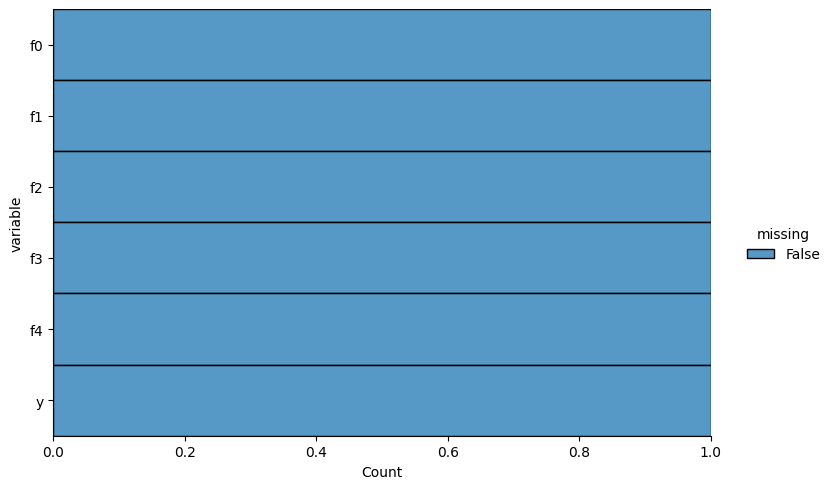

In [3]:
# check missing data
sns.displot(
    data = train_data.isna().melt(value_name="missing"),
    y = "variable",
    hue = "missing",
    multiple = "fill",
    aspect = 1.5
)

plt.show()

In [4]:
# visualize data
train_data.head()

,f0,f1,f2,f3,f4,y
0,1.7005,1.3531,1.2401,2.0728,1.6070,1.6064
1,0.7965,0.7256,0.5263,0.7339,0.8046,0.7234
2,2.8373,2.2479,3.0573,2.9302,2.8407,2.3597
3,3.0394,2.8822,2.4963,2.6470,2.7702,2.8105
4,2.0894,1.2275,1.9977,1.8091,1.1260,1.8924


In [5]:
# split independent variable (X) and dependent (Y) for train and test set
x_train = train_data.drop(columns = ["y"])
y_train = train_data["y"]
x_test = test_data.drop(columns = ["y"])
y_test = test_data["y"]

In [6]:
# extract feature names
feature_names = x_train.columns 
print("features: ", feature_names)

features:  Index(['f0', 'f1', 'f2', 'f3', 'f4'], dtype='object')


Functions to save and load models

In [7]:
import pickle

# function to save model
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

In [8]:
# function to load model
def load_model(filename):
    with open(filename, "rb") as file:
        return pickle.load(file)

### Training with NAF Regressor

Training with hyperparameter tuning

In [9]:
# import packages
from NAF.naf.forests import ForestKind, TaskType
from NAF.naf.naf_model import NeuralAttentionForest, NAFParams

# define grid hyperparameters 
naf_params = NAFParams(
    kind = ForestKind.EXTRA,
    task = TaskType.REGRESSION,
    mode = "end_to_end",
    n_epochs= 100,
    lr = 0.01,
    lam = 0.0,
    target_loss_weight = 1.0,
    hidden_size = 8,
    n_layers = 1,
    forest = dict(
        n_estimators = 100,
        min_samples_leaf = 1
    ),
    random_state = 42
)

In [10]:
# define neural attention forest
naf_model = NeuralAttentionForest(naf_params)

# fit the model
naf_model.fit(x_train.values, y_train.values)

In [11]:
# save naf model
save_model(naf_model, "models/naf_clusters_gen_v1.pkl")

Inference with XGBoost

In [12]:
# recover the model
naf_model = load_model("models/naf_clusters_gen_v1.pkl")

In [13]:
# evaluate model
from sklearn.metrics import r2_score

def calculate_r2(model, x, y):
    # predict values
    y_pred = model.predict(x.values)
    # calculate R^2 score
    r2 = r2_score(y.values, y_pred)
    
    return r2

In [14]:
# calculate r2 for training set
r2_train = calculate_r2(naf_model, x_train, y_train)
print("R^2 train score: ", r2_train)

R^2 train score:  1.0


In [15]:
# calculate r2 for test set
r2_test = calculate_r2(naf_model, x_test, y_test)
print("R^2 test score: ", r2_test)

R^2 test score:  0.9998565034380402


### Explainable AI

In [19]:
import shap

# apply tree explainer
explainer = shap.Explainer(naf_model, x_test.values)
shap_values = explainer(x_test.values)

ExactExplainer explainer: 376it [3:51:27, 37.03s/it]                           


#### Global Explanations

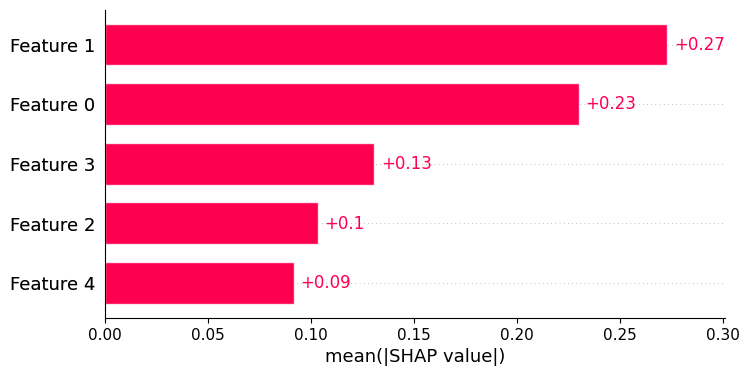

In [20]:
# global explanations using feature importance plots
shap.plots.bar(shap_values)

##### Interpretation: Global explanations using feature importante plots  
SHAP values explain the average contribution of each feature to the model predictions. The length of the bar indicates the average magnitude of a feature's impact on model predictions, and color indicates if impact is positive (red) or negative (blue).
- The feature f0 has the highest average SHAP value, which means it generally has the strongest influence in the model's predictions.  

- The influence of f1 is next, with an average SHAP value smaller than f0, but still significant.  

- f3 and f4 have a smaller influence, but still contribute to the model.  

- f2 has the smallest average SHAP value, indicating it has the weakest influence on the model predictions.  

- The numerical labels (e.g., +0.47, +0.2, etc.) represent the specific average SHAP values, which can be understood as the average contribution of the feature to the prediction outcome. These values may be positive or negative, representing the positive or negative impact of an increase in the feature value on the prediction outcome.

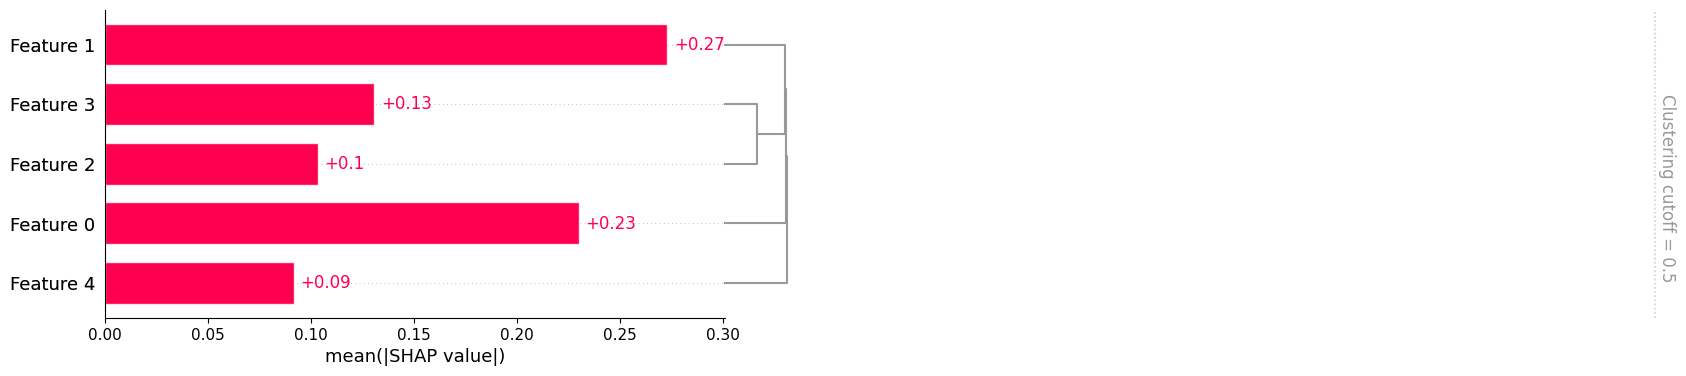

In [21]:
# bar plots with hierarchical clustering among the features
clustering = shap.utils.hclust(x_test, y_test)
shap.plots.bar(shap_values, clustering = clustering, clustering_cutoff = 0.5)

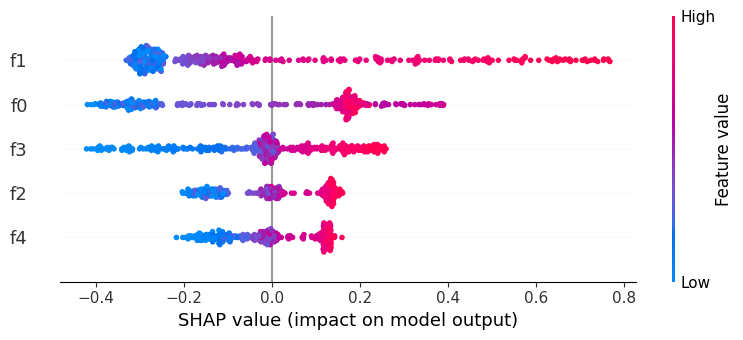

In [22]:
# global explainability with summary plots
shap.summary_plot(shap_values, x_test, feature_names)

##### Interpretation: Global explanations using summary plots
The image shows a SHAP summary plot, which provides a global view of the impact of the features on the model output. Each point on the summary plot represents a SHAP value for a feature and a specific data point. The position on the x-axis indicates the SHAP value (impact on model output), while the color represents the value of the feature from low (blue) to high (red).  

- Feature f0 has a wide spread of SHAP values, indicating a variable impact on the model output. The cluster of points to the far right suggests instances where f0 has a high positive impact on the model output.  

- Feature f1 also shows a variable impact but with a slight skew towards positive SHAP values, suggesting that, overall, it tends to positively influence the model's predictions.  

- Feature f3 displays a concentration of SHAP values around zero, suggesting that for many data points, it doesn't have a strong impact on the output. However, there are still some points with higher positive and negative values, indicating that under certain conditions, it can have a substantial impact.  

- Feature f4 shows a more balanced distribution of SHAP values around zero, with many points clustered close to the center, indicating a generally lower impact on the model's output.  

- Feature f2 has the least spread of SHAP values and is concentrated around zero, suggesting it has the smallest impact on the model output across the data points.  

The plot indicates the importance and the direction of the impact each feature has on the model's predictions. Features that have a mix of high and low SHAP values (both positive and negative) across different data points indicate interactions with other features or non-linear effects within the model.

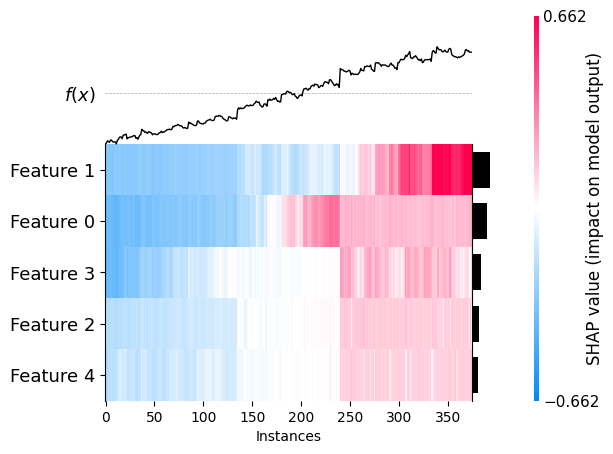

In [23]:
# global explainability with heat maps
shap.plots.heatmap(shap_values, max_display = 5)

##### Interpretation: Global explanations with heat maps  
- Impact of features on model prediction:   
Each row displays the SHAP values of the corresponding feature, with the intensity of the color indicating the size of the feature value's impact on the model output. The deeper the color, the greater the impact. Red represents a positive impact, while blue indicates a negative impact.  
  
- Magnitude of feature values:   
The color gradient from blue to red represents feature values from low to high. This suggests that we can identify which feature values play a significant role in the model's predictions.  
  
- Comparison between different samples:   
Horizontally, the variation in the impact of features across different samples can be observed. For some samples, a specific feature may have a substantial positive impact, while for others, the same feature may have a negative or smaller impact.  
  
- Distribution of model predictions:  
The line graph at the top of the image shows how the model's output values (predictions) vary with the samples. This helps us understand the distribution of model outputs across the entire dataset.  
  
- Features with the greatest impact:  
Based on the color bar and intensity, we can infer which features have the greatest impact on the model's output. In this particular heatmap, the f0 feature appears to have a larger positive impact across many samples, while the f2 feature seems to have the least impact on model output.  
  
- Consistency of feature impact:  
Certain features, like f0 and f1, exhibit a similar direction of impact (positive or negative) across most samples, while other features may have varying directions of impact across different samples.

Partial dependency plot (PDP) for f0


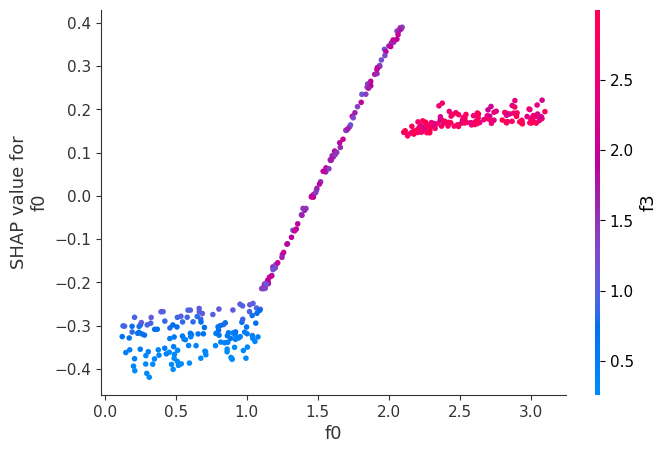

Partial dependency plot (PDP) for f1


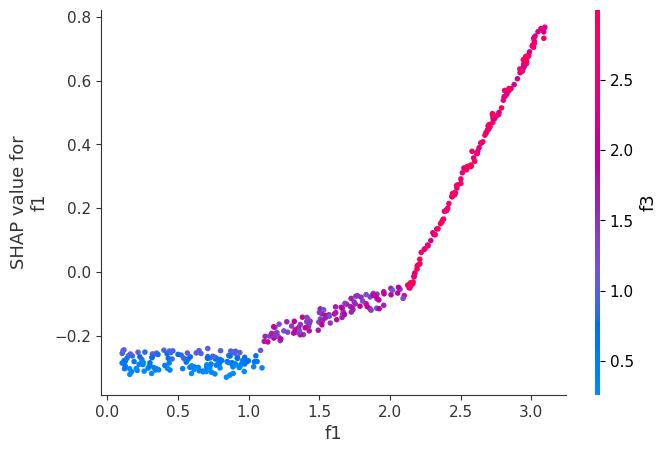

Partial dependency plot (PDP) for f2


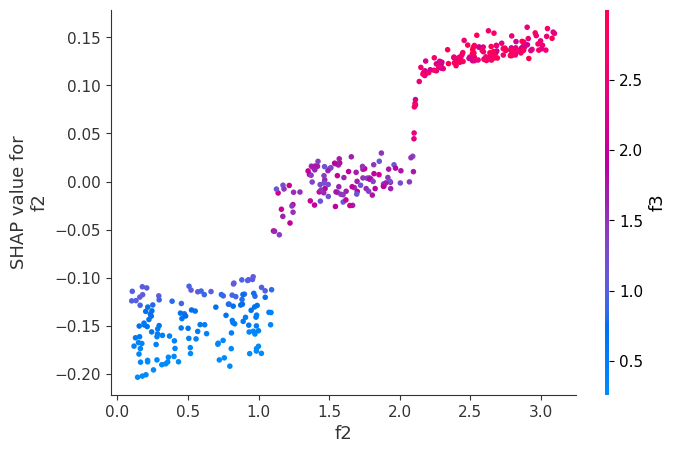

Partial dependency plot (PDP) for f3


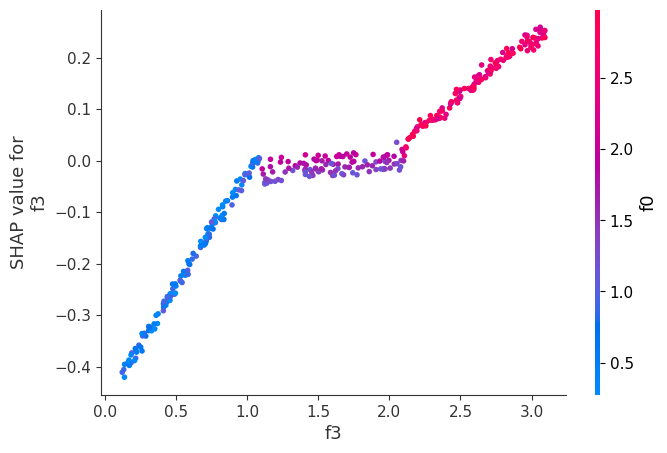

Partial dependency plot (PDP) for f4


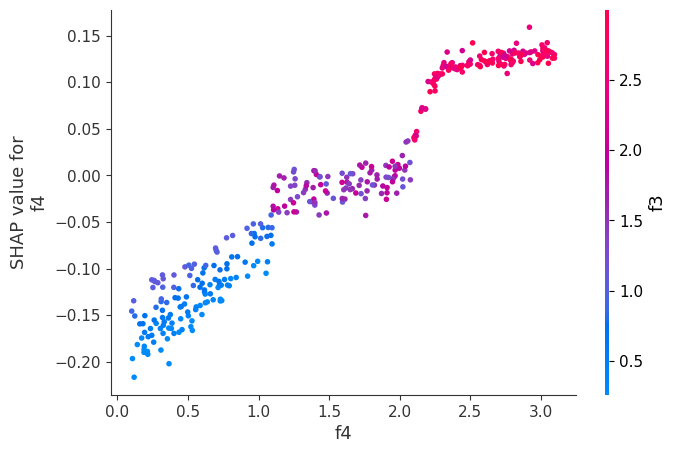

In [48]:
# global explainability with Partial Dependency PLots (PDP)
for col in feature_names.values:
    print(f"Partial dependency plot (PDP) for {col}")
    shap.dependence_plot(col, shap_values.values, x_test, feature_names = feature_names)

##### Interpretation: Global explanations with PDP  
The series of plots are Partial Dependence Plots (PDPs) generated using SHAP values. These plots are used to show the relationship between a particular feature and the impact it has on the predictive model’s output. Here’s an analysis of each plot:

- **f0**: The SHAP values for f0 increase significantly as the value of f0 increases. There seems to be a threshold around the value of f0 where the impact on the model output changes from negative (or no impact) to a positive impact. This suggests that higher values of f0 have a strong positive effect on the model's prediction.
- **f1**: This plot indicates a clear positive correlation between the feature value and its SHAP value, meaning as f1 increases, its impact on the model's output also increases. There is a relatively smooth gradient, suggesting a consistent and predictable relationship.
- **f2**: For f2, the SHAP values scatter around zero but then show some positive impact as the feature value increases. The impact is not as strong or as consistent as f0 or f1, indicating that f2 may have a less significant or more complex relationship with the output.
- **f3**: Similar to f1, f3 shows a positive correlation with the SHAP values. The impact on the model's output increases as the value of f3 increases, indicating that f3 is an important feature for the model's predictions.
- **f4**: The SHAP values for f4 are primarily clustered around zero but then show variability with both positive and negative impacts as the feature value increases. The relationship here is less clear, suggesting that the influence of f4 on the model output may depend on interactions with other features or is not linear.
- These PDPs are powerful because they can show whether the relationship between the target and the features is linear, monotonic, or more complex. For example, if SHAP values for a feature increase as the feature values increase, this indicates a positive correlation, which can be linear or non-linear. If SHAP values decrease, it indicates a negative correlation. If there is no clear trend or if there is a lot of variability in SHAP values at different feature values, this might suggest a non-monotonic relationship or interaction effects with other features.